In [4]:
import pandas as pd
import numpy as np
from scipy import stats  #统计包，求密度函数对应值

### 一、读取数据close、loght

In [5]:
# 读取原始数据，为了计算rtn数据，其中有用的序列是close
ask = pd.read_csv('EURUSD_GMT23_daily.csv')
# matlab计算中的loght，数据来matlab
loght = pd.read_excel('loght.xls').loght 
# 查看数据
ask.head()

,Time,open,high,low,close,volume
0,2003/5/5 0:00,1.12177,1.13019,1.12030,1.12804,981092.902
1,2003/5/6 0:00,1.12798,1.14510,1.12738,1.14368,1061122.702
2,2003/5/7 0:00,1.14367,1.14448,1.13275,1.13677,1056796.602
3,2003/5/8 0:00,1.13675,1.15092,1.13026,1.15026,1058908.702
4,2003/5/9 0:00,1.15002,1.15376,1.14362,1.14907,1063989.002


### 二、构建rtn数据

In [6]:
cl = ask.close  # 取close列
# shift(1)移动一步
rtn = (cl - cl.shift(1))/cl.shift(1)
rtn = np.log(1+rtn)*100  
# 去空 并把 index从0开始重新排序（和matlab有区别）
cl = cl.iloc[1:,]; cl.index = range(4087)
rtn = rtn.iloc[1:,]; rtn.index = range(4087)  # 日收益率,回报率
n = len(rtn)  # 获得序列的长度 

### 三、基础参数设定

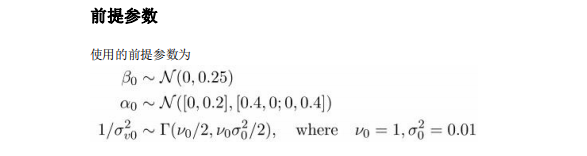

In [9]:
# MCMC，基本参数
beta0 = 0  
Sigma_beta0 = 0.25  
alpha0 = np.array([0,0.2])  
Sigma_alpha0 = np.diag([0.4,0.4])   # 产生对角矩阵
nu0 = 1  
Sigmav0 = 0.01   

### 四、构建参数容器，用于后面装更新的参数

In [10]:
# MCMC，循环次数,抽样次数
nmcmc = 10000
# 存储参数结果
beta_mcmc = np.zeros([nmcmc,1])  # beta 的10000次更新结果
logh_mcmc = np.zeros([n,nmcmc])  # 序列更新10000次
alpha_mcmc = np.zeros([nmcmc,len(alpha0)]) # 10000*2，alpha=[alpha1,plpha2]
Sigmav_mcmc = np.zeros([nmcmc,1])  # Sigamav的10000次更新结果

### 五、Garch产生的初始值
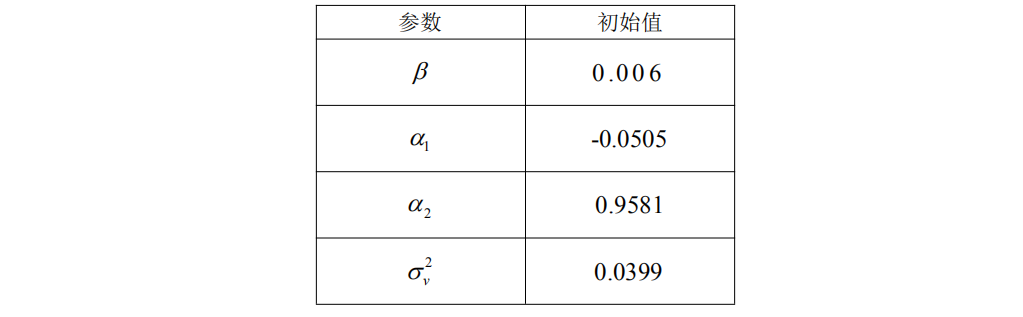

In [11]:
# 下面参数来自matlab，由garch(1,1)模型得到（二）过程
# betai
betai = 0.005726854308386
# alphai
alphai =np.array([-0.0504936326785964,0.958122817848944])
# Sigmavi
Sigmavi = 0.039922552961321
# sigma_loghp = Sigmav0
sigma_loghp = 0.01

### 六、开始MCMC的过程

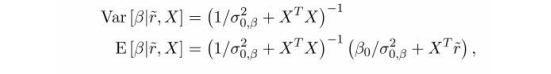

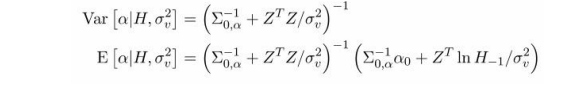

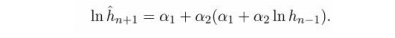

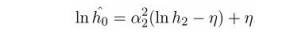

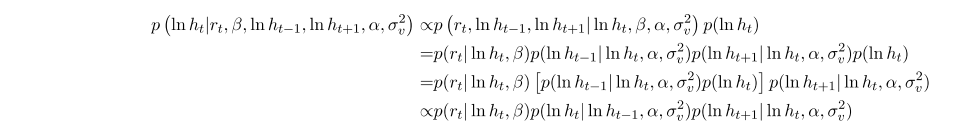

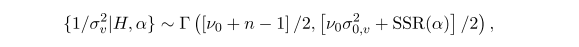

In [13]:
# python中不能直接矩阵相乘，np.dot(),还要验证矩阵或向量长度
for i in range(nmcmc):
    #  Gibbs sampling: beta ，来自公式推导1.
    rtn_new = rtn/np.sqrt(np.exp(loght))  # reformat return series
    x = 1./np.sqrt(np.exp(loght))
    V_beta = 1/(np.dot(x.T,x) + 1/Sigma_beta0)
    E_beta = V_beta*(beta0/Sigma_beta0+np.dot(x.T,rtn_new))
    betai = np.random.normal(E_beta,np.sqrt(V_beta))
    
    # Metropolis sampling: ht
    logh0 = alphai[1]**2*(loght[1]-alphai[0]/(1-alphai[1])) + alphai[0]/(1-alphai[1])   # lnh0, ita=alphai[0]/(1-alphai[1])
    loghn1 = alphai[0]+alphai[1]*(alphai[0]+alphai[1]*loght[n-1]) # lnht+1
    loghf1 = list(loght[1:]);loghf1.append(loghn1); loghf1 = np.array(loghf1)   # log of one-step forward ht，[lnh1,lnh2,...lnht+1]
    loghb1 = list(loght[:-1]);loghb1.insert(0,logh0); loghb1 = np.array(loghb1)   # log of one-step backward ht，[lnh0,lnh1,lnh2,...lnht]
    ##################重点################################################################################################################
    #  propose new ht，下面来自于MH算法。stats.norm.pdf求概率值。
    loghp = np.random.normal(loght,sigma_loghp)  # 原始的随机分布，在nmcmc次抽样后会靠近loght的分布。
    #  check log ratio of the posterior probability
    #  np.dot(np.array([[i,j] for i,j in zip(np.ones(n),list(loghb1))]),alphai.T) 难点 表示 lnht|lnht-1的均值
    #  stats.norm.pdf(x,均值，标准差）
    logr = np.log(stats.norm.pdf(loghp, np.dot(np.array([[i,j] for i,j in zip(np.ones(n),list(loghb1))]),alphai.T),np.sqrt(Sigmavi))) + \
        np.log(stats.norm.pdf(loghf1,np.dot(np.array([[i,j] for i,j in zip(np.ones(n),list(loghp))]),alphai.T),np.sqrt(Sigmavi))) + \
        np.log(stats.norm.pdf(rtn-betai,0,np.sqrt(np.exp(loghp)))) -\
        np.log(stats.norm.pdf(loght, np.dot(np.array([[i,j] for i,j in zip(np.ones(n),list(loghb1))]),alphai.T),np.sqrt(Sigmavi))) - \
        np.log(stats.norm.pdf(loghf1,np.dot(np.array([[i,j] for i,j in zip(np.ones(n),list(loght))]),alphai.T),np.sqrt(Sigmavi))) - \
        np.log(stats.norm.pdf(rtn-betai,0,np.sqrt(np.exp(loght))))
    # accept or not,在这里修改了loght，拒绝或接受
    idxi = np.log(np.random.rand(n))< logr
    loght[idxi] = loghp[idxi]
    ######################################################################################################################################
#     count_accept = count_accept + idxi.nnz
    
    #  Gibbs sampling: alpha,来自公式
    zt = np.array([[1,i] for i in loght[:-1]]);
    V_alpha =np.linalg.inv(np.linalg.inv(Sigma_alpha0) + np.dot(zt.T,zt)/Sigmavi)  #np.linalg.inv（）求逆
    E_alpha = np.dot(V_alpha,(np.dot(np.linalg.inv(Sigma_alpha0),alpha0.T)+ np.dot(zt.T,loght[1:])/Sigmavi))
    alphai = np.random.multivariate_normal(E_alpha,V_alpha)
    
    #  Gibbs sampling: Sigmav，来自公式
    SSR = sum((loght[1:]-np.dot(zt,alphai.T))**2)
    Sigmavi = 1/(np.random.gamma((nu0+n-1)/2,2/(nu0*Sigmav0+SSR)))  # 产生服从gamma分布随机数
    
    # collect result,记录数据
    beta_mcmc[i] = betai
    logh_mcmc[:,i]= loght
    alpha_mcmc[i,:] = alphai
    Sigmav_mcmc[i] = Sigmavi

### 七、结果可视化

Text(0, 0.5, 'beta')

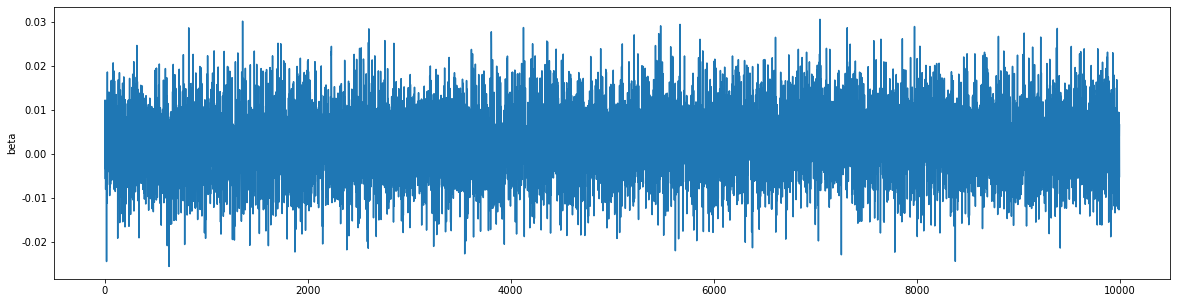

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(range(10000),beta_mcmc)
plt.ylabel('beta')

Text(0, 0.5, 'alpha2')

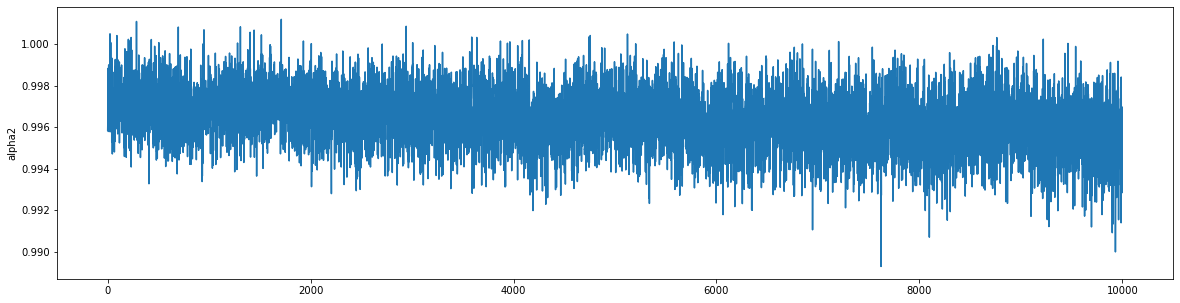

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(range(10000),alpha_mcmc[:,1])
plt.ylabel('alpha2')

Text(0, 0.5, 'alpha1')

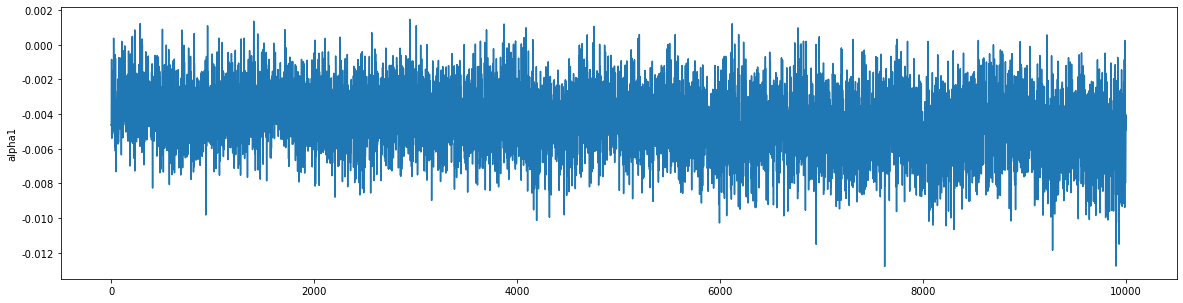

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(range(10000),alpha_mcmc[:,0])
plt.ylabel('alpha1')

Text(0, 0.5, 'Sigmav')

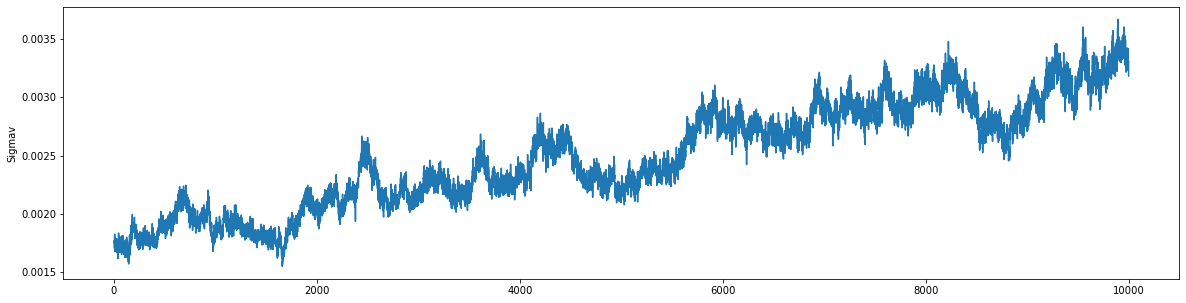

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(range(10000),Sigmav_mcmc)
plt.ylabel('Sigmav')